# Neural Networks in PyTorch
## Chapter 6: Testing SLPs and CNNs on Synthetic Images
*Yen Lee Loh, 2022-12-3*

We now turn to binary classification of images.  An image is represented by a matrix of pixel values.  For machine learning purposes, such a matrix can be flattened into a vector.  We will be working with 8x8 grayscale images ($x_{ij}$), which are simply 64-element vectors ($x_d$) as far as the machine is concerned.

In this demo, we generate an artificial set of images.  Some of these images contain a particular pattern, and some are just white noise. 
The images are labeled $y_n=0$ (for white noise) or $y_n=1$ (for pattern).
We split our dataset into a training set ($x_{nd}^T, y_n^T$) and a validation set ($x_{nd}^V, y_d^V$).
First, we train a neural network on the training set.
Then, we validate it on the validation set.

We will see that a single-layer perceptron (SLP) learns "by rote".  If it has seen a pattern in the top or left, it may not recognize the pattern if it appears at the bottom.  In contrast, a convolutional neural network (CNN) is able to automatically recognize the same pattern shifted by some amount.  This gives it the ability to generalize.  In this demo, a CNN is superior to a SLP.

---
## 1.  Setup

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from collections.abc import Iterable
rng = np.random.default_rng()
plt.rcParams.update ({'font.family':'monospace', 'font.size':11})
'''
  gallery(xnij)
  Display an array of grayscale images 
'''
def gallery(xnij, cmap='viridis', labels=None, size=1):  # size is in inches
  nmax = len(xnij)
  cols = min(20,nmax) ; rows = (nmax+cols-1)//cols
  wspace = 0.02 ; hspace = 0.02
  if isinstance (labels, Iterable) or labels!=None:   # if user has supplied labels
    hspace = .35
    
  fig,axs = plt.subplots (rows,cols, figsize=(cols*size*(1+wspace),rows*size*(1+hspace)), gridspec_kw={'wspace':wspace,'hspace':hspace})
  if nmax==1: axs = np.array([[axs]])
  axs = axs.flatten()
  for ax in axs:
      ax.axis ('off')
  for n in range(nmax):
      ax = axs[n]
      if isinstance (cmap, Iterable) and not isinstance (cmap, str):
        c = cmap[n]
      else:
        c = cmap
      ax.imshow (xnij[n], cmap=c)
      ax.set_aspect('equal')
      if isinstance (labels, Iterable):
        ax.set_title (str(labels[n]))

def train(xnd, ynd, model, lossFunc, epochs=10000, learningRate=0.001, lossTarget=0.01, reportInterval=1000):
  optimizer = torch.optim.Adam(model.parameters(), lr=learningRate)
  model.train()                  # put model in training mode
  for t in range(epochs):      # t is the epoch number
    Ynd = model(xnd)             # uppercase Y = model prediction
    loss = lossFunc(Ynd,ynd)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    F = loss.item()
    if t % reportInterval == 0 or t==epochs:
      print('Training epoch {}/{}\t Loss = {:.4f}'.format(t, epochs, F))
    if F < lossTarget:
      print('Training epoch {}/{}\t Loss = {:.4f} < lossTarget\n'.format(t, epochs, F))
      return
  print ('Warning: loss > lossTarget!\n')
  
def metrics (Yn, yn):   # Yn are model outputs, yn are true outputs
  nmax = len(yn)
  ymax = max(yn)+1
  confmat = np.zeros ([ymax, ymax], dtype=int)   # confmat[Y][y]
  for n in range(nmax): confmat[yn[n], Yn[n]] += 1
  ntot = np.sum(confmat)
  nerr = ntot - np.trace(confmat)
  return ntot,nerr,confmat

---
## 2. Fabricate a synthetic dataset

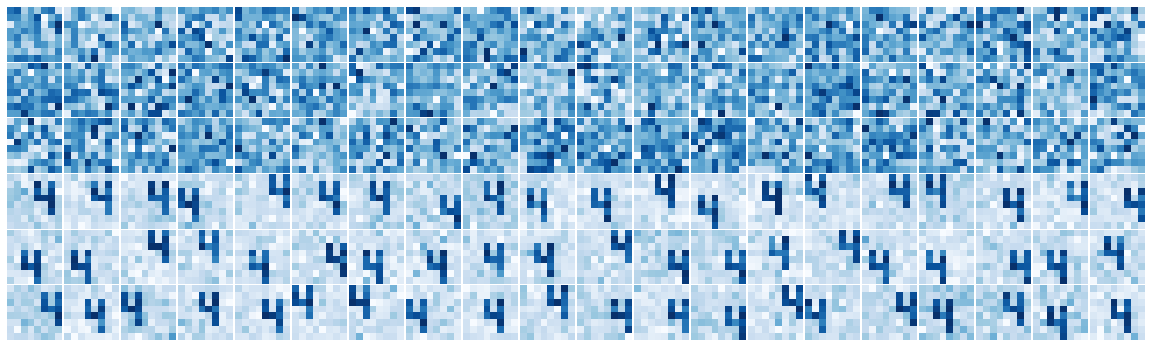

((120, 8, 8), torch.Size([120, 64]), torch.Size([120, 1]))

In [6]:
#================ SET USER-DEFINED PARAMETERS
imax,jmax = 8,8
nmaxT = 20          # number of training examples
nmaxV = 100         # number of validation cases
nmax = nmaxT+nmaxV  # total
noiselevel = 0.15
pattern1 = np.array ([
  [1,0,1],
  [1,0,1],
  [1,1,1],
  [0,0,1],
  [0,0,1],
])
#================ FABRICATE THE DATASET
xnij = []
yn = []
for iter in range(nmax//2):
  xij = noiselevel*rng.standard_normal ([imax,jmax])      # noise
  xnij += [xij]
  yn += [0]
for iter in range(nmax//2):
  xij = noiselevel*rng.standard_normal ([imax,jmax])      # noise
  i0,j0 = rng.integers (0, [imax+1-pattern1.shape[0],jmax+1-pattern1.shape[1]], [2])       # shift
  xij[i0:i0+pattern1.shape[0], j0:j0+pattern1.shape[1]] += pattern1  # stamp
  xnij += [xij]
  yn += [1]
xnij = np.array(xnij)
yn = np.array(yn)
nmax,imax,jmax = xnij.shape
#================ SHIFT AND NORMALIZE?
# for n in range(nmax):
#   xnij[n] -= np.mean (xnij[n])
#   xnij[n] /= np.std (xnij[n])
#================ CONVERT TO STANDARD FORM
xnd = torch.tensor (xnij, dtype=torch.float32).flatten(1,-1)
ynd = torch.tensor (yn, dtype=torch.float32).reshape(-1,1)
gallery(xnij, cmap='Blues') ; plt.show()
xnij.shape, xnd.shape, ynd.shape

The above dataset consists of 60 grayscale images, each of size 8x8 pixels.  Half of these are Gaussian noise.  The other half contain the digit '4' at a random position.  One would think it should be easy for a NN to learn to recognize whether an image contains the digit '4'.

In [7]:
#================ SPLIT INTO TRAINING (T) AND VALIDATION (V) SETS
# indices = rng.permutation (nmax)
# indicesT = indices[:nmaxT]; xndT = xnd[indicesT]; yndT = ynd[indicesT]
# indicesV = indices[-nmaxV:]; xndV = xnd[indicesV]; yndV = ynd[indicesV]
indices0, = np.where (yn==0) ; rng.shuffle (indices0)
indices1, = np.where (yn==1) ; rng.shuffle (indices1)
indicesT = np.concatenate ([indices0[:nmaxT//2],indices1[:nmaxT//2]])   ; xndT = xnd[indicesT]; yndT = ynd[indicesT]
indicesV = np.concatenate ([indices0[-nmaxV//2:],indices1[-nmaxV//2:]]) ; xndV = xnd[indicesV]; yndV = ynd[indicesV]

---
## 3. Train and validate an SLP on this dataset

Training epoch 0/1000	 Loss = 0.7504
Training epoch 100/1000	 Loss = 0.1073
Training epoch 200/1000	 Loss = 0.0431
Training epoch 300/1000	 Loss = 0.0241
Training epoch 400/1000	 Loss = 0.0157
Training epoch 500/1000	 Loss = 0.0112
Training epoch 538/1000	 Loss = 0.0100 < lossTarget

SLP Weights:


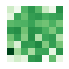

Training Dataset:


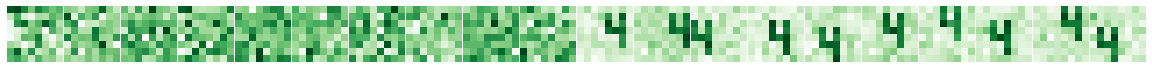

Validation Dataset (any misclassified images are shown in red):


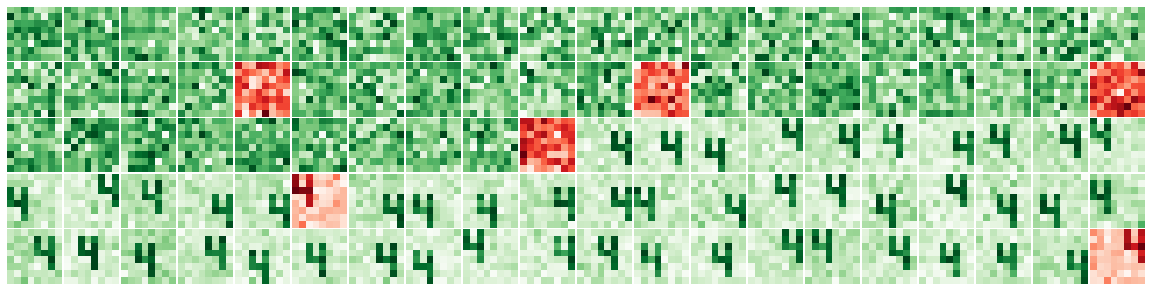

Training error   = 0/20 =  0.0%    Confusion matrix = [[10, 0], [0, 10]]
Validation error = 6/100 =  6.0%    Confusion matrix = [[46, 4], [2, 48]]


In [27]:
#================ DEFINE SLP
model = nn.Sequential(              # input 16x16
  nn.Linear    (imax*jmax, 1),      # imax*jmax+1 learnable parameters
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())  # lr=0.1
train (xndT, yndT, model, lossFunc, epochs=1000, reportInterval=100, learningRate=0.01)

#================ EVALUATE (VALIDATE)
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ DISPLAY WEIGHTS
wij  = model[0].weight.detach().numpy().reshape(imax,jmax)
b    = model[0].bias.detach().item()
plt.show() ; print ('SLP Weights:')
gallery ([wij], cmap='Greens')
#================ DISPLAY IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Dataset:')
gallery (xndT.reshape(-1,imax,jmax), cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Dataset (any misclassified images are shown in red):')
gallery (xndV.reshape(-1,imax,jmax), cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

The single-layer perceptron can recognize the digit '4' if it occurs at a location that it has seen before, but it is unable to generalize to situations where the digit '4' occurs at a different place.  Try running this section several times.  Nearly every time, you will find that the training error is zero but the validation error is nonzero.

---
## 3. Train and validate a simple CNN on this dataset

Training epoch 0/1000	 Loss = 0.6483
Training epoch 100/1000	 Loss = 0.1280
Training epoch 200/1000	 Loss = 0.0640
Training epoch 300/1000	 Loss = 0.0390
Training epoch 400/1000	 Loss = 0.0265
Training epoch 500/1000	 Loss = 0.0193
Training epoch 600/1000	 Loss = 0.0148
Training epoch 700/1000	 Loss = 0.0117
Training epoch 777/1000	 Loss = 0.0100 < lossTarget

CNN Weights


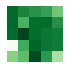

Training Dataset:


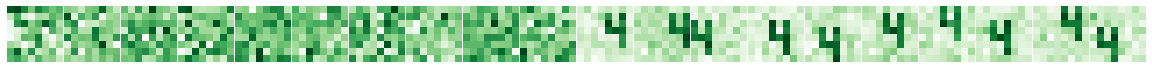

Validation Dataset (any misclassified images are shown in red):


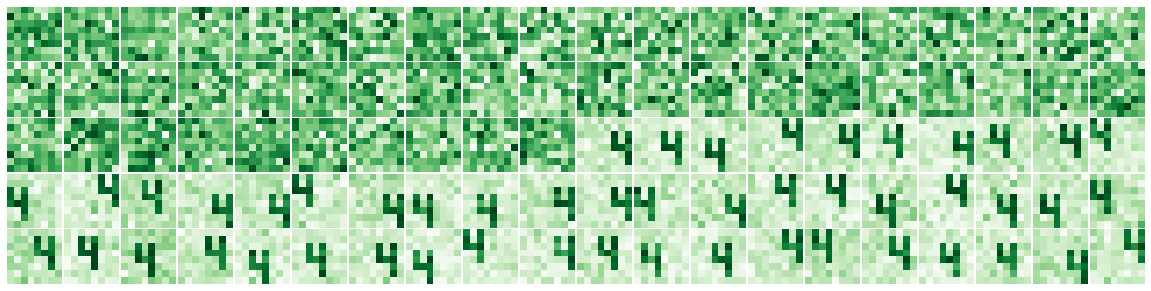

Training error   = 0/20 =  0.0%    Confusion matrix = [[10, 0], [0, 10]]
Validation error = 0/100 =  0.0%    Confusion matrix = [[50, 0], [0, 50]]


In [28]:
#================ DEFINE A CNN
cmax = 1                            # number of channels
kmax = 5                            # kernel size
model = nn.Sequential(              # input 16x16
  nn.Unflatten (1, (1,imax,jmax)),  # out   1x16x16
  nn.Conv2d    (1,cmax, kmax),      # convolutional layer with cmax*kmax*kmax learnable parameters
  nn.ReLU(),
  nn.MaxPool2d (imax-kmax+1),
  nn.Flatten(),    
  nn.Linear(cmax,1),                # cmax+1 learnable parameters
  nn.Sigmoid()
)
lossFunc  = nn.BCELoss()
train (xndT, yndT, model, lossFunc, epochs=1000, reportInterval=100, learningRate=0.01)

#================ EVALUATE (VALIDATE)
model.eval()             # choose evaluation mode
YndT = model(xndT)
YndV = model(xndV)
YnT = YndT.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynT = yndT.detach().numpy().flatten().astype(int)          # this is already an integer
YnV = YndV.detach().numpy().round().flatten().astype(int)  # round to either 0 or 1
ynV = yndV.detach().numpy().flatten().astype(int)          # this is already an integer
#================ EXAMINE WEIGHTS
wccij = model[1].weight.detach()
cmax,_,I,J = wccij.shape
bc = model[1].bias.detach()
plt.show() ; print ('CNN Weights')
gallery (wccij.reshape (cmax, I, J), cmap='Greens') #labels=['Channel {}'.format(c) for c in range(cmax)], 
#================ DISPLAY IMAGES AND CLASSIFICATIONS
plt.show() ; print ('Training Dataset:')
gallery (xndT.reshape(-1,imax,jmax), cmap=np.where(YnT==ynT,'Greens','Reds'));  #labels=['T{}'.format(n) for n in range(nmax)],
plt.show() ; print ('Validation Dataset (any misclassified images are shown in red):')
gallery (xndV.reshape(-1,imax,jmax), cmap=np.where(YnV==ynV,'Greens','Reds')); plt.show();
#================ PRINT METRICS
ntot,nerr,Cnn = metrics (YnT, ynT)
print("Training error   = {:}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))
ntot,nerr,Cnn = metrics (YnV, ynV)
print("Validation error = {:}/{:} = {:4.1f}%    Confusion matrix = {}".format (nerr, ntot, 100*nerr/ntot, Cnn.tolist()))

Try re-running this section several times.  (Each time you do this, the network is initialized randomly before training.)  You will observe two types of outcomes:

- Training error is 0%, validation error 0%, and weights resemble numeral '4'.  (Or sometimes there may be multiple copies of the '4'.)  The network has learned to identify images correctly.

- Training error is 0%, but validation error is LARGE, and weights do NOT resemble numeral '4'.  The network has been misled by noise in the data, and is paying attention to the wrong features.  It is overfitting the training set.

In general, the CNN performs much better than the SLP.

---